The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat).

Data ource: Download data from this source
https://www.kaggle.com/competitions/dogs-vs-cats/data

## 1. Preprocessing (Getting data)

In [1]:
# Let import some library

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import random
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
pwd

'C:\\Users\\sajja\\Downloads\\dogs-vs-cats'

In [3]:
os.listdir()

['.ipynb_checkpoints',
 'dogs-vs-cats',
 'DogsVsCats.ipynb',
 'img.jpg',
 'model1_catsVSdogs_10epoch.h5',
 'model_20epochs.h5',
 'sampleSubmission.csv',
 'test1',
 'train']

In [4]:
# Let get data set from directory

filenames=os.listdir("./train")

categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]   # names are like cat.1 we split with "." and select the first part
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)

df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [5]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [6]:
df["category"].value_counts()  # Data is balanced equal label!

0    12500
1    12500
Name: category, dtype: int64

(<AxesSubplot:xlabel='category', ylabel='count'>,)

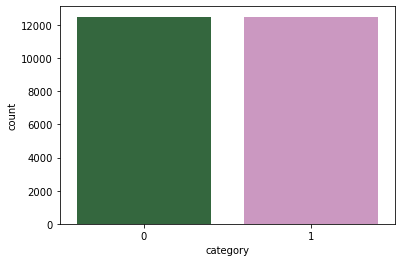

In [7]:
sns.countplot(x=df["category"], palette='cubehelix'),

In [8]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,random_state=101)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15


img_width=128
img_height=128
img_size=(img_width,img_height)
Image_Channels=3

In [9]:
train_datagen = ImageDataGenerator(rotation_range=10,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "./train/",x_col='filename',
                                                    y_col='category',
                                                 target_size=img_size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)


validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
                                                            validate_df, 
                                                            "./train/", 
                                                            x_col='filename',
                                                            y_col='category',
                                                            target_size=img_size,
                                                            class_mode='categorical',
                                                            batch_size=batch_size
                                                        )

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## 2. Creating Model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization

model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_width,img_height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [12]:
#Some early stopping criteria
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,
                                            verbose = 1,factor = 0.5,min_lr = 0.00001)

callbacks = [earlystop,learning_rate_reduction]

In [ ]:
#Let train model for 20 epochs
epochs=20   

history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
1333/1333 [==============================] - 620s 463ms/step - loss: 0.7467 - accuracy: 0.6291 - val_loss: 0.6648 - val_accuracy: 0.7011 - lr: 0.0010
Epoch 2/20
1333/1333 [==============================] - 665s 499ms/step - loss: 0.5256 - accuracy: 0.7452 - val_loss: 1.2884 - val_accuracy: 0.5145 - lr: 0.0010
Epoch 3/20
1333/1333 [==============================] - 549s 412ms/step - loss: 0.4614 - accuracy: 0.7869 - val_loss: 0.3692 - val_accuracy: 0.8378 - lr: 0.0010
Epoch 4/20
1333/1333 [==============================] - 509s 382ms/step - loss: 0.4129 - accuracy: 0.8147 - val_loss: 0.3809 - val_accuracy: 0.8236 - lr: 0.0010
Epoch 5/20
1333/1333 [==============================] - 493s 370ms/step - loss: 0.3842 - accuracy: 0.8307 - val_loss: 0.3974 - val_accuracy: 0.8066 - lr: 0.0010
Epoch 6/20
 450/1333 [=========>....................] - ETA: 1:06:12 - loss: 0.3540 - accuracy: 0.8507

In [ ]:
model.save("model_20epochs.h5") 

In [ ]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [ ]:
#Model was trained for 20 epochs, for higher accuracy we can increase number of epochs

## 3. Testing the model with unseen data

In [ ]:
test_filenames = os.listdir("./test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_df.head()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                 "./test1/",x_col='filename',y_col=None,
                                                 target_size=img_size,
                                                 class_mode=None,
                                                 batch_size=batch_size)

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1) # Selecting the categry which has highest probablity


# Let convert prediction to geberator classes
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
sample_test = test_df.tail(9)
sample_test.head()

In [ ]:
sample_test = test_df.head(6)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./test1/"+filename, target_size=img_size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
os.listdir()    # 'img.jpg will be used for prediction'

In [ ]:
results={
    0:'cat',
    1:'dog'
}


from PIL import Image
import numpy as np
im=Image.open("img.jpg")
im=im.resize(img_size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=np.argmax(model.predict(im), axis=1)
print(pred[0],"-->", "This is a:",results[pred[0]])